# Train And Test - Regression XPU

## Linear Regression

- Imports
  - standard libs
  - 3rd party libs
  - alpabetical or logical grouping
- Set random seed
- Config and Hyperparams
- Dataset and Dataloader
- Model definition/class
- Helper functions (training, eval, visualization)
- Then main code

Note: You can flip torch.amp on and off to test on XPU.

2025-01-16 14:16:24,191 - root - INFO - Seed set to: 198187925
2025-01-16 14:16:24,193 - root - INFO - Using device: xpu
2025-01-16 14:16:24,218 - root - INFO - X_train shape: torch.Size([4000, 1]), y_train shape: torch.Size([4000, 1])
2025-01-16 14:16:24,218 - root - INFO - X_test shape: torch.Size([1000, 1]), y_test shape: torch.Size([1000, 1])
2025-01-16 14:16:24,219 - root - INFO - Seed has been set: 42
2025-01-16 14:16:24,221 - root - INFO - Seed has been set: 42
2025-01-16 14:16:24,223 - root - INFO - X_train device: xpu:0, y_train device: xpu:0
2025-01-16 14:16:24,223 - root - INFO - X_test device: xpu:0, y_test device: xpu:0
Training: 100%|███████████████████████████████████████████████████████████████████| 1500/1500 [00:03<00:00, 380.77it/s]
2025-01-16 14:16:28,165 - root - INFO - Epochs: 1500 | Train loss: 0.00208 | Test loss: 0.00592 | Accuracy: 99.99408%
2025-01-16 14:16:28,194 - root - INFO - Saving model to: models\LinearRegressionModel_model_0.pth


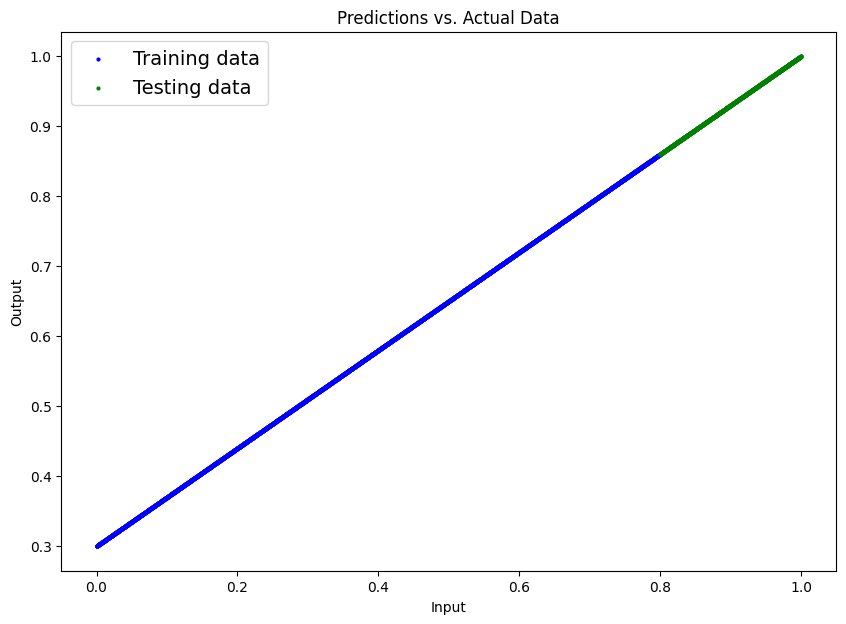

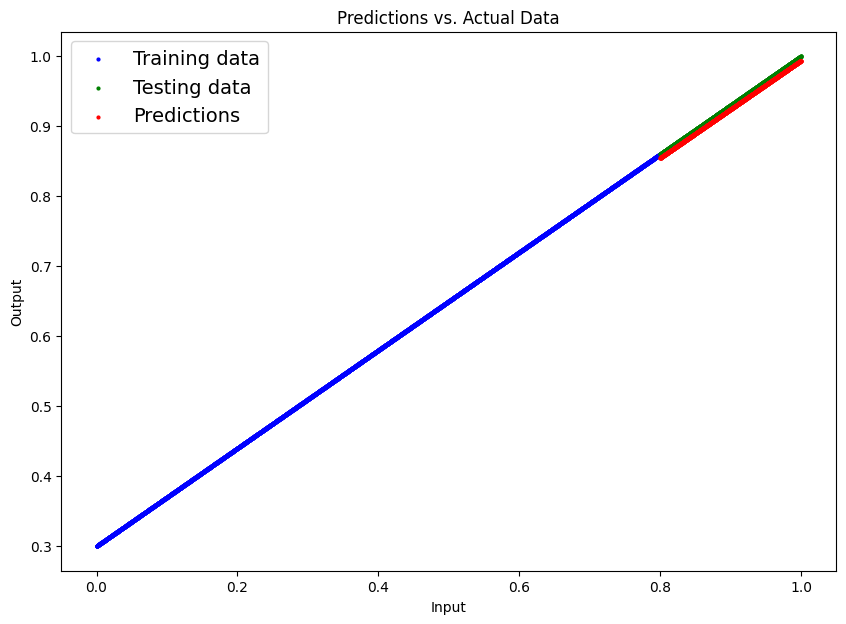

In [36]:
import logging
from pathlib import Path
import random

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.amp import GradScaler, autocast
from tqdm import tqdm

# Set or adjust your hyperparameters and amp/cpu override
hp = {
    "start": 0,
    "end": 1,
    "step": 0.0002,
    "weight": 0.7,
    "bias": 0.3,
    "learning_rate": 0.005,
    "epochs": 1500,
    "random_seed": 42,
    "randomize_seed": True,
    "cpu_only": False,
}

# Logging configuration
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Randomize seed if set to True
if hp['randomize_seed']:
    hp['random_seed'] = random.randint(0, 1000000000)
logging.info(f"Seed set to: {hp['random_seed']}")   

def get_device():
    """
    This will check for an Intel XPU device and return it if available, otherwise it will return cpu.

    Returns the torch device to use.
    """
    if hp['cpu_only'] == False:
        device = "xpu" if torch.xpu.is_available() else "cpu"
        if torch.xpu.is_available():
            device = "xpu"
        elif torch.cuda.is_available():
            device = "cuda"
        else:
            device = "cpu"

        logging.info(f"Using device: {device}")
        return device
    else:
        logging.info("Using CPU only")
        return "cpu"

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Generate dataset and return the training and test data
def generate_dataset(start=0, end=1, step=0.0002, weight=0.7, bias=0.3):
    """
    Generate a dataset for a sample linear regression problem.

    Args:
        start (float): The start of the X values.
        end (float): The end of the X values.
        step (float): The step between X values.
        weight (float): The weight of the linear equation.
        bias (float): The bias of the linear equation.

    Returns:
        tuple: X_train, y_train, X_test, y_test
    """
    
    X = torch.arange(start, end, step).unsqueeze(dim=1)
    y = weight * X + bias 
      
    train_split = int(0.8 * len(X))
    X_train, y_train = X[:train_split], y[:train_split]
    X_test, y_test = X[train_split:], y[train_split:]

    return X_train, y_train, X_test, y_test

# Plotting function to visualize the data
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.title("Predictions vs. Actual Data")
    plt.legend(prop={"size": 14});

def set_seed(seed=42):
    """
    Set seed for reproducibility.
    """
    torch.manual_seed(seed)
    if device == "xpu":
        torch.xpu.manual_seed(seed)
    elif device == "cuda":
        torch.cuda.manual_seed(seed)
    logging.info(f"Seed has been set: {seed}")

def move_to_device(x, y, X_test, y_test, device="cpu"):
    """
    Moves data to the target device.
    """
    x = x.to(device)
    y = y.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    logging.info(f"X_train device: {x.device}, y_train device: {y.device}")
    logging.info(f"X_test device: {X_test.device}, y_test device: {y_test.device}")
    return x, y, X_test, y_test

def train_test_model(model, X_train, y_train, X_test, y_test, loss_fn, optimizer, epochs, device="cpu"):
    """
    Train and test a PyTorch model.

    Args:
        model (torch.nn.Module): A PyTorch model.
        X_train (torch.Tensor): Training data (features).
        y_train (torch.Tensor): Training labels.
        X_test (torch.Tensor): Testing data (features).
        y_test (torch.Tensor): Testing labels.
        loss_fn (torch.nn.Module): An instance of a PyTorch loss function.
        optimizer (torch.optim.Optimizer): An instance of a PyTorch optimizer.
        epochs (int): Number of epochs to train the model for.
        device (str): The target device to run the model on.

    Returns:
        tuple: Training loss, testing loss
    """
    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()

        if device != "cpu":
            with torch.amp.autocast(device):
                y_pred = model(X_train)
                loss = loss_fn(y_pred, y_train)
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
        else:
            y_pred = model(X_train)
            loss = loss_fn(y_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()

        with torch.inference_mode():
            if device != "cpu":
                with torch.amp.autocast(device):
                    test_pred = model(X_test)
            else:
                test_pred = model(X_test)

            test_loss = loss_fn(test_pred, y_test)

    accuracy = 100 - test_loss.item()
    logging.info(f"Epochs: {epochs} | Train loss: {loss:.5f} | Test loss: {test_loss:.5f} | Accuracy: {accuracy:.5f}%")

    return loss, test_loss

# Main function to run training, testing, saving of the model
def main():
    device = get_device()

    X_train, y_train, X_test, y_test = generate_dataset(start=hp['start'], end=hp['end'], step=hp['step'], weight=hp['weight'], bias=hp['bias'])

    plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu())

    logging.info(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    logging.info(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    set_seed(hp['random_seed'])

    # This should instantiate the model and move it to the GPU
    model_0 = LinearRegressionModel()
    model_0.to(device)

    loss_fn = nn.L1Loss()
    optimizer = torch.optim.SGD(params=model_0.parameters(), lr=hp['learning_rate'])

    set_seed(hp['random_seed'])

    X_train, y_train, X_test, y_test = move_to_device(X_train, y_train, X_test, y_test, device)

    if hp['cpu_only'] == False:
        scaler = torch.amp.GradScaler(device)

    train_test_model(model=model_0, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, loss_fn=loss_fn, optimizer=optimizer, epochs=hp['epochs'], device=device)

    # Turn on evaluation mode so we don't update the model weights
    model_0.eval()

    # Make predictions on the test data
    with torch.inference_mode():
        y_preds = model_0(X_test)

    plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), y_preds.cpu())

    # Create models directory if it doesn't exist
    MODEL_PATH = Path("models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)

    # Create model save path if it doesn't exist
    MODEL_NAME = "LinearRegressionModel_model_0.pth"
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

    # Save the model state dict 
    logging.info(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH) 

    # Load the newly saved model
    loaded_model_0 = LinearRegressionModel()
    loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))
    loaded_model_0.to(device)

    # Evaluate loaded model
    loaded_model_0.eval()
    with torch.inference_mode():
        loaded_model_0_preds = loaded_model_0(X_test)
    y_preds == loaded_model_0_preds

# Run the main function
if __name__ == '__main__':
    main()